**Importing data**

In [1]:
# Enable making data frames
import pandas as pd

# Importing numpy
import numpy as np

#For visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")

To filter the tweets we must firstly download the tweet file before we concatenated the tweets on a daily basis (to only include Tesla tweets)

In [2]:
elon_musk = pd.read_csv('https://raw.githubusercontent.com/MariaRosendal/Tesla-tweets/main/elon_musk_v2.csv')

In [3]:
# Make dates to datetime format
elon_musk['date'] = pd.to_datetime(elon_musk.date)

In [4]:
#Set the date as index
elon_musk.set_index('date', inplace=True)

In [5]:
#Let's have a look
elon_musk.head()

,username,tweet,replies_count,retweets_count,likes_count,tweet_clean
date,,,,,,
2020-11-16,elonmusk,@Maisie_Williams 🎶 Toss a bitcoin to ur Witcher 🎶,1148,3448,66981,🎶 Toss a bitcoin to ur Witcher 🎶
2020-11-16,elonmusk,@Kristennetten 😉,100,37,2203,😉
2020-11-16,elonmusk,"@WhatsupFranks @michaelmina_lab CureVac, Moder...",72,75,1090,"CureVac, Moderna a few others. Tesla makes th..."
2020-11-16,elonmusk,@michaelmina_lab Creating synthetic mRNA for c...,96,90,1221,Creating synthetic mRNA for cures/vaccines is ...
2020-11-16,elonmusk,@gaertner_anne @Neuro_Skeptic @DresdenTea @jud...,55,32,1412,Haha


# Filtering on "Tesla" topic

In this section we filter out tweets that does not include words including "Tesla" or words related to the "Tesla" topics identified in the topic modelling

In [6]:
# We firstly make all words lower case in order to filter
elon_musk['tweet'] = elon_musk['tweet'].str.lower()

In [7]:
# Create colum defining if tweet contains words including Tesla or related words in "Tesla topic"
elon_musk['tweet_keep'] = elon_musk['tweet'].str.contains("tesla|car")
#|video|order|mile|model|electric

# Make a copy of the data frame only including tweets with above words 
elon_musk = elon_musk[elon_musk['tweet_keep'] == True].copy()

## Remove top retweets column (no longer needed)
elon_musk.drop('tweet_keep', axis=1, inplace=True)

In [8]:
elon_musk.shape

(2302, 6)

In [9]:
elon_musk

,username,tweet,replies_count,retweets_count,likes_count,tweet_clean
date,,,,,,
2020-11-16,elonmusk,"@whatsupfranks @michaelmina_lab curevac, moder...",72,75,1090,"CureVac, Moderna a few others. Tesla makes th..."
2020-11-16,elonmusk,"@samtalkstesla i’m ok, thanks for asking. no s...",240,120,2841,"I’m ok, thanks for asking. No symptoms for pas..."
2020-11-14,elonmusk,"@teslaownerssv cool, but please be super cauti...",171,132,5748,"Cool, but please be super cautious. Expect two..."
2020-11-13,elonmusk,@john_beans @dirtytesla interesting,60,32,747,Interesting
2020-11-13,elonmusk,the carousel turns ever faster,2867,4369,84939,The carousel turns ever faster
...,...,...,...,...,...,...
2015-12-17,elonmusk,vance article on self-driving cars was inaccur...,80,503,1090,Vance article on self-driving cars was inaccurate
2015-11-24,elonmusk,"@id_aa_carmack yep, good points. i hope you ge...",16,49,323,"Yep, good points. I hope you get back into spa..."
2015-11-24,elonmusk,@tobiasvdb the f9 booster can reach low orbit ...,11,63,208,The F9 booster can reach low orbit as a single...


In [10]:
# Let's give it a new name and drop unwanted columns
tweets_filtered = elon_musk.copy()

# Remove tweet column (no longer needed as we must use tweet_clean for sentiment analysis)
tweets_filtered.drop(columns=['tweet'], axis=1, inplace=True)

In [11]:
#Let's see if it worked
tweets_filtered.head()

,username,replies_count,retweets_count,likes_count,tweet_clean
date,,,,,
2020-11-16,elonmusk,72,75,1090,"CureVac, Moderna a few others. Tesla makes th..."
2020-11-16,elonmusk,240,120,2841,"I’m ok, thanks for asking. No symptoms for pas..."
2020-11-14,elonmusk,171,132,5748,"Cool, but please be super cautious. Expect two..."
2020-11-13,elonmusk,60,32,747,Interesting
2020-11-13,elonmusk,2867,4369,84939,The carousel turns ever faster


In [12]:
# Too apply the sentiment score for each day we firstly concatenate the tweets on the same day
tweets_filtered_daily = pd.DataFrame(tweets_filtered.groupby(tweets_filtered.index).tweet_clean.apply('. '.join))
tweets_filtered_daily.columns =['conc_tweet']

In [13]:
tweets_filtered_daily.head(5)

,conc_tweet
date,
2015-11-20,We are looking for hardcore software engineers...
2015-11-24,"Yep, good points. I hope you get back into spa..."
2015-12-17,Vance article on self-driving cars was inaccurate
2015-12-19,This article does not appreciate that Tesla is...
2015-12-20,Just reviewed mission params w SpaceX team. Mo...


In [14]:
#Add column with tweet count
tweets_filtered_daily['tweets_count'] = tweets_filtered.groupby(tweets_filtered.index).tweet_clean.count()

#Sentiment score on filtered data

Applying the same approach as in the initial sentiment scoring

In [ ]:
!pip install twython

In [ ]:
#Importing nltk
import nltk

# Importing sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

In [17]:
analyzer = SentimentIntensityAnalyzer()

# Generating sentiment scores for each tweet and a compound (including all scores)
tweets_filtered_daily['neg_sentiment'] = tweets_filtered_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['neg'])
tweets_filtered_daily['neu_sentiment'] = tweets_filtered_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
tweets_filtered_daily['pos_sentiment'] = tweets_filtered_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
tweets_filtered_daily['compound_sentiment'] = tweets_filtered_daily['conc_tweet'].apply(lambda x:analyzer.polarity_scores(x)['compound'])


In [18]:
#Let's see how many rows we have now
tweets_filtered_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 817 entries, 2015-11-20 to 2020-11-16
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   conc_tweet          817 non-null    object 
 1   tweets_count        817 non-null    int64  
 2   neg_sentiment       817 non-null    float64
 3   neu_sentiment       817 non-null    float64
 4   pos_sentiment       817 non-null    float64
 5   compound_sentiment  817 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.7+ KB


In [19]:
# We now drop all rows that are neither classified as neg, neu or pos (as they would only create noise in the model)
tweets_filtered_daily = tweets_filtered_daily[~((tweets_filtered_daily.neg_sentiment == 0) & (tweets_filtered_daily.neu_sentiment == 0) & (tweets_filtered_daily.pos_sentiment == 0))]

#Let's have a look at the dataframe again (we can see that there was no rows with all 0)
tweets_filtered_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 814 entries, 2015-11-20 to 2020-11-16
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   conc_tweet          814 non-null    object 
 1   tweets_count        814 non-null    int64  
 2   neg_sentiment       814 non-null    float64
 3   neu_sentiment       814 non-null    float64
 4   pos_sentiment       814 non-null    float64
 5   compound_sentiment  814 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.5+ KB


In [20]:
tweets_filtered_daily.head()

,conc_tweet,tweets_count,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
date,,,,,,
2015-11-20,We are looking for hardcore software engineers...,2,0.051,0.833,0.116,0.4215
2015-11-24,"Yep, good points. I hope you get back into spa...",2,0.058,0.685,0.257,0.7424
2015-12-17,Vance article on self-driving cars was inaccurate,1,0.000,1.000,0.000,0.0000
2015-12-19,This article does not appreciate that Tesla is...,1,0.096,0.807,0.098,0.0108
2015-12-20,Just reviewed mission params w SpaceX team. Mo...,1,0.000,0.803,0.197,0.5994


#Stock data

In [21]:
# As we have already cleaned and preprocessed the stock data, we import the file
tesla = pd.read_csv('https://raw.githubusercontent.com/MariaRosendal/Tesla-tweets/main/tesla_v2.csv')

In [22]:
#Let's check if the categorical variable (stock increase/decrease) is there
tesla.head()

,Date,High,Low,Open,Close,Volume,Adj Close,daily_change,daily_change_pred,change_categorical
0,2015-11-20,45.000000,42.716000,44.698002,44.001999,22003500.0,44.001999,-0.807037,-1.027225,Decrease
1,2015-11-23,43.835999,42.936001,43.470001,43.549999,12631000.0,43.549999,-1.027225,0.229626,Increase
2,2015-11-24,44.200001,43.000000,43.074001,43.650002,12401500.0,43.650002,0.229626,5.218785,Increase
3,2015-11-25,46.166000,44.076000,44.268002,45.928001,19954000.0,45.928001,5.218785,0.857858,Increase
4,2015-11-27,46.450001,45.402000,46.212002,46.321999,9747000.0,46.321999,0.857858,-0.582877,Decrease


In [23]:
# Make dates to datetime format
tesla['date'] = pd.to_datetime(tesla.Date)


#Set the date as index
tesla.set_index('date', inplace=True)

# Combined data

**Merge stocks and tweets**

Left merged was used previously to only include trading days (excl. weekends and holidays). However, as our dataset now only includes Tesla tweets, there will be a lot of trading days with no tweets and filling-foward the sentiment values would results in a lot of noise. Therefore, we make an inner merge this time (i.e. we only include trading days where there has been a tweet).

In [24]:
# Creating merged DataFrame
merged_filtered = pd.merge(tesla.loc[:,['change_categorical', 'daily_change_pred', 'daily_change']], 
                           tweets_filtered_daily.loc[:,'tweets_count':'compound_sentiment'], 
                           left_index=True, right_index=True, how='inner')

In [25]:
merged_filtered.head()

,change_categorical,daily_change_pred,daily_change,tweets_count,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
date,,,,,,,,
2015-11-20,Decrease,-1.027225,-0.807037,2,0.051,0.833,0.116,0.4215
2015-11-24,Increase,5.218785,0.229626,2,0.058,0.685,0.257,0.7424
2015-12-17,Decrease,-1.255414,-0.477589,1,0.000,1.000,0.000,0.0000
2016-01-20,Increase,0.639149,-2.940598,1,0.000,1.000,0.000,0.0000
2016-02-10,Increase,4.733071,-3.089377,2,0.000,0.837,0.163,0.6682


*Correlations**

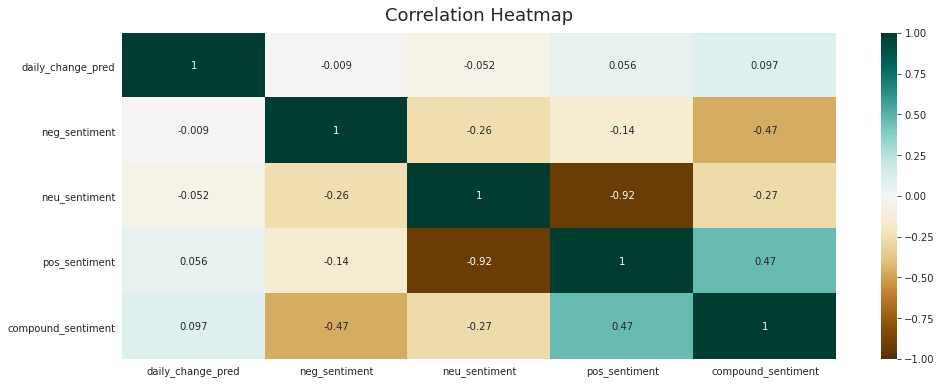

In [26]:
# Visualizing the corelations between all variables

merged_corr = merged_filtered.loc[:,['daily_change_pred', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound_sentiment']]

merged_corr.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(merged_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# Predicting stock movements (filtered tweets only)

## Setting x and y variables

In [27]:
# Importing StandardScaler
from sklearn.preprocessing import StandardScaler

# Scaling data
scaled_data = StandardScaler().fit_transform(merged_filtered.loc[:,'neg_sentiment':'compound_sentiment'])

In [28]:
scaled_data_df = pd.DataFrame(scaled_data)
scaled_data_df.describe()

,0,1,2,3
count,5.580000e+02,5.580000e+02,5.580000e+02,5.580000e+02
mean,-2.168715e-16,-2.315949e-16,-2.089129e-17,-5.950288e-18
std,1.000897e+00,1.000897e+00,1.000897e+00,1.000897e+00
min,-6.419358e-01,-4.091049e+00,-9.778726e-01,-2.922846e+00
25%,-6.419358e-01,-4.162525e-01,-6.507230e-01,-8.216319e-01
50%,-6.419358e-01,1.125048e-01,-1.471027e-01,1.510620e-01
75%,3.049428e-01,6.001806e-01,3.130786e-01,8.890097e-01
max,6.186259e+00,1.209775e+00,4.451996e+00,1.293786e+00


StandardScaler enables us to obtain scaled data with means very close to 0 (note, the values contain high exponents) and the standard deviations close to 1. 

In [29]:
# As we have text values fo y, we must use LabelEncoder to transform to integers

# Importing packages
from sklearn.preprocessing import LabelEncoder

# Defining X and y values (transforming text to integers for y)
X = scaled_data

y = merged_filtered.loc[:,'change_categorical']
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

In [30]:
# Importing train test split
from sklearn.model_selection import train_test_split

In [31]:
# Defining the train (80%) and test (20%) data set (no need to set shuffle=False anylonger, as we have not preserved the time-series element when filtering on few tweets)
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.8, test_size=0.2, random_state = 1)

In [32]:
# Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Defining models
m_lr = LogisticRegression()
m_rf = RandomForestClassifier()
m_xgb = XGBClassifier()
m_knn = KNeighborsClassifier()
m_svc = SVC(probability=True)

## Baseline model

In [33]:
# Import dummy classifier
from sklearn.dummy import DummyClassifier

# Import classification report
from sklearn.metrics import classification_report

In [34]:
# Set parameters
dummy = DummyClassifier(strategy='stratified', random_state=1)

# "Train" model 
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=1, strategy='stratified')

In [35]:
# Model evaluation
dummy.score(X_test, y_test)

0.4642857142857143

In [36]:
# Classification report
y_pred_dummy = dummy.predict(X_test)
print(classification_report(y_test, y_pred_dummy))# Finding true stock change

              precision    recall  f1-score   support

           0       0.43      0.44      0.43        52
           1       0.50      0.48      0.49        60

    accuracy                           0.46       112
   macro avg       0.46      0.46      0.46       112
weighted avg       0.47      0.46      0.46       112



In [37]:
# Create confusion matrix for basemodel

# Finding the true stock change
true_change = labelencoder_y.inverse_transform(y_test)

# Predicted change 
predicted_change_dummy = labelencoder_y.inverse_transform(y_pred_dummy)

# Obtaining confusion matrix
result_dummy = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_dummy})
pd.crosstab(result_dummy.true_change, result_dummy.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,23,29
Increase,31,29


## Gridsearch for models

In [38]:
# Setting parameters for gridsearch
parameters_lr = {'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10, 100], 'solver': ['liblinear']}
parameters_rf = {'n_estimators':[10, 50, 100, 150, 200], 'criterion':('gini', 'entropy')}
parameters_xgb = {'n_estimators':[10, 50, 100, 150, 200], 'learning_rate': [0.001, 0.005, 0.01, 0.1], 'max_depth': [4, 6, 8, 10], 'gamma': [0, 0.001, 0.005, 0.01, 0.02]}
parameters_knn = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 5, 7, 10, 25]}
parameters_svc = [{'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100, 1000]},
                  {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]}]

In [39]:
# Importing evaluation parameters
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer

# Importing gridsearch
from sklearn.model_selection import GridSearchCV

# Set scorer for optimal model
scorer = make_scorer(accuracy_score)

# Setting grid object using scorer as the scoring method 
# NOTE: the number of folds in cross validation has been decreased compared to the models using unfiltred tweets as less datapoints are now available (all non-related Tesla tweets have been removed)
grid_obj_lr = GridSearchCV(m_lr, parameters_lr, scoring=scorer, cv=5)
grid_obj_rf = GridSearchCV(m_rf, parameters_rf, scoring=scorer, cv=5)
grid_obj_xgb = GridSearchCV(m_xgb, parameters_xgb, scoring=scorer, cv=5)
grid_obj_knn = GridSearchCV(m_knn, parameters_knn, scoring=scorer, cv=5)
grid_obj_svc = GridSearchCV(m_svc, parameters_svc, scoring=scorer, cv=5)

In [40]:
# Fitting the grid search to the training data
# Note: Takes a long time to run
grid_fit_lr = grid_obj_lr.fit(X_train, y_train)
grid_fit_rf = grid_obj_rf.fit(X_train, y_train)
grid_fit_xgb = grid_obj_xgb.fit(X_train, y_train)
grid_fit_knn = grid_obj_knn.fit(X_train, y_train)
grid_fit_svc = grid_obj_svc.fit(X_train, y_train)

## Model Creation

In [41]:
# Get the best model with the optimal hyperparameters
best_lr = grid_fit_lr.best_estimator_
best_rf = grid_fit_rf.best_estimator_
best_xgb = grid_fit_xgb.best_estimator_
best_knn = grid_fit_knn.best_estimator_
best_svc = grid_fit_svc.best_estimator_

In [42]:
# Fit the best model to the data
print("Logistics Regression:")
print(best_lr.fit(X_train, y_train))
print("Random forest:")
print(best_rf.fit(X_train, y_train))
print("XGBoost:")
print(best_xgb.fit(X_train, y_train))
print("Kneighbors:")
print(best_knn.fit(X_train, y_train))
print("Support Vector Classifier:")
print(best_svc.fit(X_train, y_train))

Logistics Regression:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Random forest:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBoost:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

##Model evaluation

**Accuracy**

In [43]:
# Printing accuracy scores
print("Logistic Regression:\t\t" + str(best_lr.score(X_test, y_test)))
print("Random forest:\t\t\t" + str(best_rf.score(X_test, y_test)))
print("XGBoost:\t\t\t" + str(best_xgb.score(X_test, y_test)))
print("Kneighbors:\t\t\t" + str(best_knn.score(X_test, y_test)))
print("Support Vector Classifier:\t" + str(best_svc.score(X_test, y_test)))

Logistic Regression:		0.5267857142857143
Random forest:			0.5982142857142857
XGBoost:			0.5803571428571429
Kneighbors:			0.5267857142857143
Support Vector Classifier:	0.6071428571428571


**Confusion matrix**

*Logistic regression*

In [44]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_lr = best_lr.predict(X_test)
predicted_change_lr = labelencoder_y.inverse_transform(y_pred_lr)

# Obtaining confusion matrix
result_lr = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_lr})
pd.crosstab(result_lr.true_change, result_lr.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,15,37
Increase,16,44


*Random forest*

In [45]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_rf = best_rf.predict(X_test)
predicted_change_rf = labelencoder_y.inverse_transform(y_pred_rf)

# Obtaining confusion matrix
result_rf = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_rf}) 

pd.crosstab(result_rf.true_change, result_rf.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,31,21
Increase,24,36


*XGBoost*

In [46]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_xgb = best_xgb.predict(X_test)
predicted_change_xgb = labelencoder_y.inverse_transform(y_pred_xgb)

# Obtaining confusion matrix
result_xgb = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_xgb}) 

pd.crosstab(result_xgb.true_change, result_xgb.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,30,22
Increase,25,35


*k-Nearest Neighbors*

In [47]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_knn = best_knn.predict(X_test)
predicted_change_knn = labelencoder_y.inverse_transform(y_pred_knn)

# Obtaining confusion matrix
result_knn = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_knn})

pd.crosstab(result_knn.true_change, result_knn.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,26,26
Increase,27,33


*Support Vector Classifier*

In [48]:
# Predicting the change in stock price and obtaining the initial labels of change in stock price
y_pred_svc = best_svc.predict(X_test)
predicted_change_svc = labelencoder_y.inverse_transform(y_pred_svc)

# Obtaining confusion matrix
result_svc = pd.DataFrame({'true_change': true_change, 'predicted_change': predicted_change_svc}) 

pd.crosstab(result_svc.true_change, result_svc.predicted_change)

predicted_change,Decrease,Increase
true_change,,
Decrease,25,27
Increase,17,43


**Classification reports**

In [49]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36        52
           1       0.54      0.73      0.62        60

    accuracy                           0.53       112
   macro avg       0.51      0.51      0.49       112
weighted avg       0.52      0.53      0.50       112



In [50]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58        52
           1       0.63      0.60      0.62        60

    accuracy                           0.60       112
   macro avg       0.60      0.60      0.60       112
weighted avg       0.60      0.60      0.60       112



In [51]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.55      0.58      0.56        52
           1       0.61      0.58      0.60        60

    accuracy                           0.58       112
   macro avg       0.58      0.58      0.58       112
weighted avg       0.58      0.58      0.58       112



In [52]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50        52
           1       0.56      0.55      0.55        60

    accuracy                           0.53       112
   macro avg       0.52      0.53      0.52       112
weighted avg       0.53      0.53      0.53       112



In [53]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53        52
           1       0.61      0.72      0.66        60

    accuracy                           0.61       112
   macro avg       0.60      0.60      0.60       112
weighted avg       0.61      0.61      0.60       112



**Over-/Underfitting**

In [54]:
# Importing AUC score and ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Calculating proba (if the model prediction is correct)  
best_svc_proba_train = best_svc.predict_proba(X_train)
best_svc_proba_test = best_svc.predict_proba(X_test)
 
# Calculating AUC scores
auc_score_train = roc_auc_score(y_train, best_svc_proba_train[:,1])
auc_score_test = roc_auc_score(y_test, best_svc_proba_test[:,1])
 
print(auc_score_train, auc_score_test)

0.9006658595641647 0.6230769230769231


In [55]:
# ROC curve for models
fpr1, tpr1, thresh1 = roc_curve(y_train, best_svc_proba_train[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, best_svc_proba_test[:,1], pos_label=1)
 
# Creating line for when tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

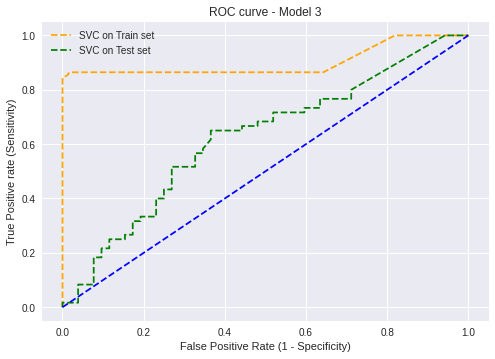

In [56]:
# Plotting the ROC curve
plt.style.use('seaborn')
 
# Plotting ROC curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVC on Train set')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='SVC on Test set')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve - Model 3')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive rate (Sensitivity)')
 
plt.legend(loc='best')
plt.savefig('ROC',dpi=500)
plt.show();

**Pemutation impotance**

In [57]:
# Importing permutation importance
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Permutation Importance')

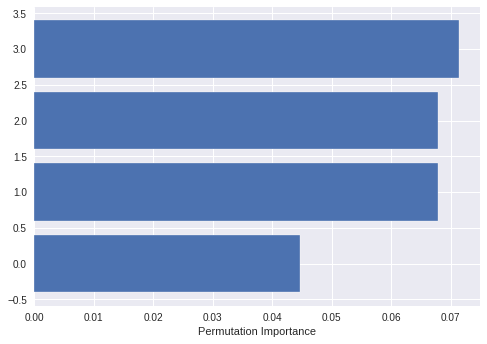

In [58]:
# Visualizaing the permutation importance (the decrease in a model score when a single feature value is randomly shuffled)
# Negative score indicates noise in the model (note: only indicative)
perm_importance = permutation_importance(best_svc, X_test, y_test, n_repeats=100)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(sorted_idx, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

**Import to pdf**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py 
from colab_pdf import colab_pdf 
colab_pdf('Predicting_stock_price_(filtered_on_Tesla_topic))')